In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from pandas import DataFrame, concat
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import MaxPooling2D, Conv2D , Flatten, Dropout, Dense, Activation
from keras.layers.normalization import BatchNormalization

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/test/test.csv
/kaggle/input/facial-keypoints-detection/training/training.csv


In [2]:
train_data = '../input/facial-keypoints-detection/training/training.csv'
test_data = '../input/facial-keypoints-detection/test/test.csv'

In [3]:
def load(test=False, cols=None):
    fname = test_data if test else train_data
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [4]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [6]:
def load2d(test=False,cols=None):
    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

## MLP

In [7]:
#Model build
model = Sequential()
model.add(Dense(256, input_dim = X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(30))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2359552   
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3870      
Total params: 2,396,318
Trainable params: 2,396,318
Non-trainable params: 0
____________________________________________

In [8]:
#Model training
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

hist = model.fit(X, y, epochs=100,batch_size=128, validation_split=0.2,verbose=False)

In [9]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

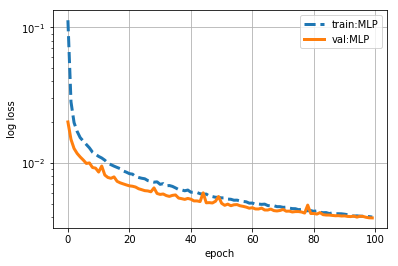

In [10]:
plot_loss(hist.history,"MLP",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [11]:
X_test, _ = load(test=True)
y_test = model.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


In [12]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

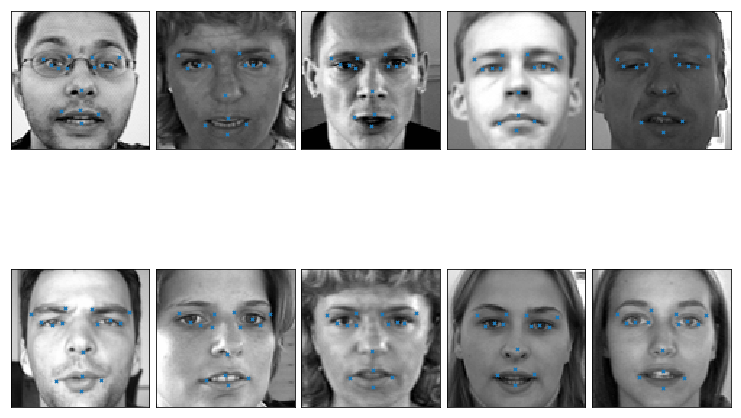

In [13]:
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

## CNN

In [14]:
X,y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [15]:
def CNN():
    model2 = Sequential()

    model2.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(96,96,1)))
    model2.add(Dropout(0.1))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(32, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(Dropout(0.2))
    model2.add(BatchNormalization())

    model2.add(Conv2D(64, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(128, 3, 3,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(Dropout(0.4))
    model2.add(BatchNormalization())

    model2.add(Flatten())

    model2.add(Dense(500, activation="relu"))
    model2.add(Dropout(0.25))

    model2.add(Dense(128, activation="relu"))
    model2.add(Dropout(0.25))

    model2.add(Dense(30))

    model2.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])
    return(model2)

In [16]:
model2 = CNN()
model2.summary()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu")`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_si

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 32)       

In [17]:
hist2 = model2.fit(X, y, nb_epoch=10,batch_size=256, validation_split=0.2,verbose=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 18s 10ms/step - loss: 0.6433 - mae: 0.5873 - accuracy: 0.0987 - val_loss: 0.1491 - val_mae: 0.3341 - val_accuracy: 0.1472
Epoch 2/10
1712/1712 [==============================] - 16s 9ms/step - loss: 0.1387 - mae: 0.3024 - accuracy: 0.1519 - val_loss: 0.1322 - val_mae: 0.3128 - val_accuracy: 0.2523
Epoch 3/10
1712/1712 [==============================] - 16s 9ms/step - loss: 0.1068 - mae: 0.2628 - accuracy: 0.1454 - val_loss: 0.1065 - val_mae: 0.2786 - val_accuracy: 0.2523
Epoch 4/10
1712/1712 [==============================] - 16s 9ms/step - loss: 0.0887 - mae: 0.2395 - accuracy: 0.2220 - val_loss: 0.0879 - val_mae: 0.2540 - val_accuracy: 0.2523
Epoch 5/10
1712/1712 [==============================] - 16s 9ms/step - loss: 0.0740 - mae: 0.2167 - accuracy: 0.2144 - val_loss: 0.0673 - val_mae: 0.2205 - val_accuracy: 0.2710
Epoch 6/10
1712/1712 [==============================] - 16s 9ms/ste

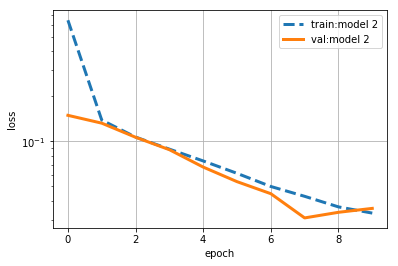

In [18]:
plot_loss(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [19]:
#model2.save('my_model2.h5')

In [20]:
sample1,_ = load(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


In [21]:
X_test,_ = load2d(test=True)

y_model2 = model2.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(train_data)).columns[:-1].values
df_y_model2 = DataFrame(y_model2,columns = landmark_nm)

ImageId    1783
Image      1783
dtype: int64


In [22]:
FIdLookup = '../input/facial-keypoints-detection/IdLookupTable.csv'

IdLookup = read_csv(os.path.expanduser(FIdLookup))

def prepare_submission(y_pred4,filename):
    '''
    save a .csv file that can be submitted to kaggle
    '''
    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred4[landmark].iloc[irow-1]])
    
    submit = DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
    if filename == "model3":
       submit.to_csv("model2.csv",index=False) 
    else:
        submit.to_csv("special.csv",index=False)

In [23]:
#prepare_submission(df_y_pred_s,"special")    
prepare_submission(df_y_model2,"model2")

(27124, 2)
